<a href="https://colab.research.google.com/github/SAHRBIGDATA/AprendizajeProfundo_UAX/blob/main/Clase_04_Redes_convolucionales_SergioHita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 4.3.1.- Modelo de clasificación

#### Shallow model
Veamos el modelo de clasificación básico ya visto la semana pasada:

In [ ]:
# from https://github.com/fyu/pytorch_examples/blob/master/mnist_hogwild/train.py

Cargamos los módulos de PyTorch.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

Hacemos que los gráficos aparezcan en el notebook:

In [ ]:
%matplotlib inline

Parámetros del modelo

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Creamos los data-loaders para muestrear los datos de entrada en minibatches y reordenar aleatoriamente:

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Utilicemos matplotlib para ver las imágenes de entrada y sus etiquetas:

Shape: torch.Size([1000, 1, 28, 28])


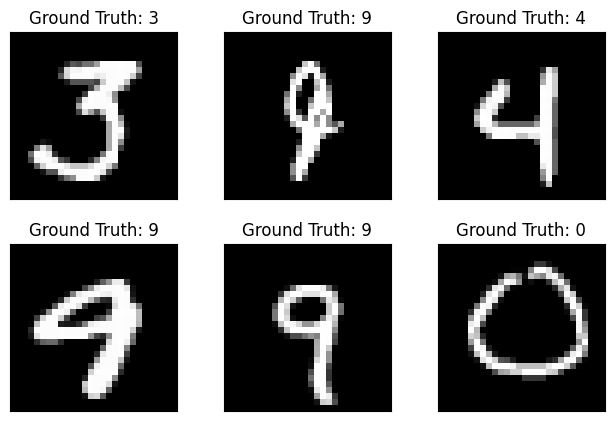

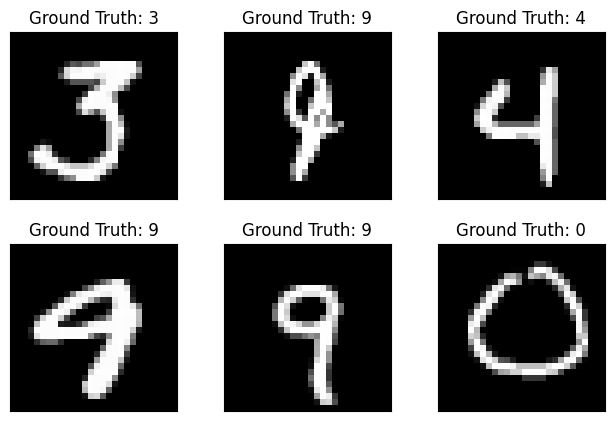

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(f'Shape: {example_data.shape}')

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

Definimos la estructura de la red neuronal convolucional:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Creamos un objeto de la clase Net que acabamos de definir, así como un optimizador SGD con momentum (podría ser otro, daría resultados parecidos en este ejemplo):

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

Definimos los procedimientos de entrenamiento y validación:

In [ ]:
# Train
#########
train_losses = []
train_counter = []

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

# Test
#######
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


Invocamos los métodos de test y entrenamos los epochs antes establecidos:

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-29-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

Representamos la evolución de la función de pérdida en test y training:

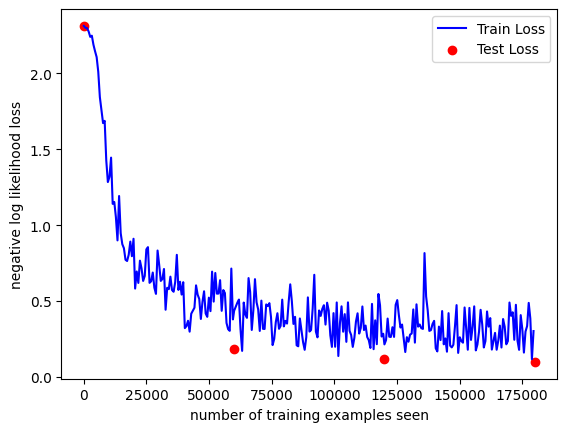

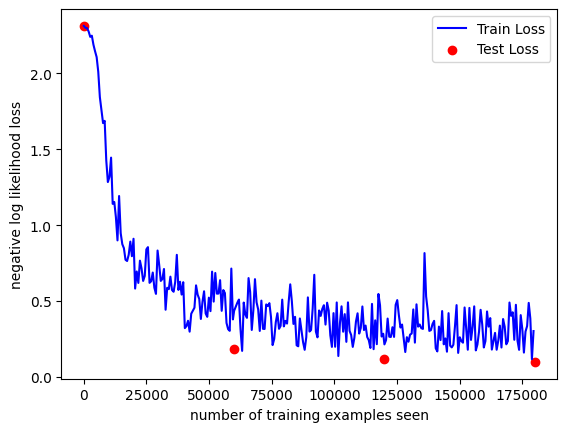

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

Comprobemos, por último, qué está devolviendo el modelo y en qué medida está acertando:

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 0:
        output = network(data)
        for i,digit in enumerate(output):
            input_list = list(digit.detach().numpy())
            input_list2 = [np.exp(v) for v in input_list]
            input_list2 = input_list2/np.sum(input_list2)
            max_value = max(input_list)
            pred = input_list.index(max_value)
            ok_ko = "OK  :-)" if pred == target[i] else "KO :-( !!!!!!"
            print(f"\n* Predicho {pred} / Real {target[i]} -> {ok_ko} \n{input_list}")
    else:
        break


* Predicho 1 / Real 1 -> OK  :-) 
[-18.562557, -0.00020716428, -10.20662, -12.399311, -11.088883, -14.578715, -13.728029, -9.509247, -9.526921, -13.078919]

* Predicho 1 / Real 1 -> OK  :-) 
[-17.939138, -0.000608974, -10.692119, -12.291627, -9.170013, -13.503129, -13.437244, -10.3033495, -7.7310963, -13.127701]

* Predicho 1 / Real 1 -> OK  :-) 
[-16.886814, -0.0004449093, -9.493635, -10.748202, -9.865551, -12.705581, -12.212115, -8.867891, -8.883971, -11.651737]

* Predicho 5 / Real 5 -> OK  :-) 
[-13.09945, -19.396097, -21.550812, -9.453307, -21.35935, -0.00011526874, -12.201125, -24.015238, -10.583862, -12.334123]

* Predicho 3 / Real 3 -> OK  :-) 
[-14.975607, -9.766125, -11.187783, -0.0039333133, -15.577841, -5.591122, -16.65086, -14.059836, -10.124372, -9.407587]

* Predicho 8 / Real 8 -> OK  :-) 
[-13.352105, -16.245972, -14.001781, -13.64648, -17.417698, -7.4049644, -12.528428, -16.944086, -0.00065245794, -10.212532]

* Predicho 7 / Real 7 -> OK  :-) 
[-8.245939, -16.767048, 

<ipython-input-29-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


#### Transfer learning
Veamos ahora un modelo de clasificación utilizando transfer learning:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# code from ---> https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# images ---> https://download.pytorch.org/tutorial/hymenoptera_data.zip

Tras bajar las imágenes, carguemos las librerías que vamos a necesitar:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Carguemos los datos y sobre ellos creemos los data-loaders:

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/data/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Veamos cómo son las imágenes:

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


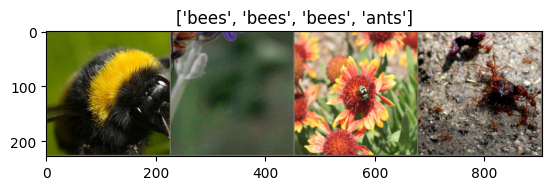

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Procedimiento de entrenamiento. Obsérvese que únicamente lee una red neuronal (model) y no se establece aquí que se esté realizando transfer learning, pues esto ya viene con la propia configuración de la red y el estado de los gradientes (sólo actualizable la última capa fully-connected "fc"):

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Procedimiento para entrenar cada "n" imágenes mientras se visualizan resultados (se le invocará luego):

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Nos descargamos un modelo ResNet18 (18 capas) a través de la librería torchvisions.models, ya pre-entrenado. A continuación, creamos una capa fully-connected con el mismo número de entradas que el modelo ResNet18 que sirve de backbone, sustituyendo esta capa del modelo por la nueva. Obsérvese que previamente el modelo ResNet18 congeló sus capas mediante "requires_grad=False", mientras que la capa nueva que hemos puesto en sustitución a la última capa viene por defecto con "requires_grad=True", lo que significa que sólo entrenará esa capa.

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Se entrena el modelo con la configuración que le hemos dicho:

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6270 Acc: 0.6762
val Loss: 0.2358 Acc: 0.9412

Epoch 1/9
----------
train Loss: 0.4259 Acc: 0.7992
val Loss: 0.1919 Acc: 0.9477

Epoch 2/9
----------
train Loss: 0.4528 Acc: 0.7951
val Loss: 0.1946 Acc: 0.9412

Epoch 3/9
----------
train Loss: 0.5272 Acc: 0.7787
val Loss: 0.2328 Acc: 0.9150

Epoch 4/9
----------
train Loss: 0.5539 Acc: 0.7705
val Loss: 0.4351 Acc: 0.8562

Epoch 5/9
----------
train Loss: 0.4268 Acc: 0.8197
val Loss: 0.1840 Acc: 0.9412

Epoch 6/9
----------
train Loss: 0.4257 Acc: 0.8320
val Loss: 0.1919 Acc: 0.9346

Epoch 7/9
----------
train Loss: 0.3053 Acc: 0.8648
val Loss: 0.1855 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.3778 Acc: 0.8443
val Loss: 0.1848 Acc: 0.9542

Epoch 9/9
----------
train Loss: 0.4008 Acc: 0.8156
val Loss: 0.2216 Acc: 0.9412

Training complete in 1m 41s
Best val Acc: 0.954248


Aplicamos la función de visualización con fine-tuning:

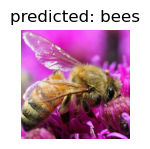

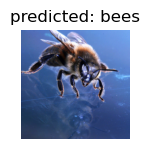

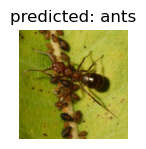

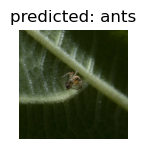

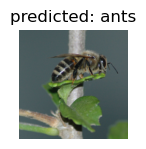

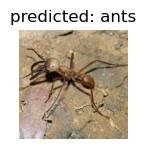

In [ ]:
visualize_model(model_conv)
plt.ioff()
plt.show()

### 4.3.2.- Modelo de detección

Para el caso de detección de objetos, vamos a utilizar el detector YOLO v5 para PyTorch (actualmente la última versión es v7) ya preentrenado, sin fine-tuning de dominio, para ver qué tal funciona en términos generales.

In [ ]:
#from https://github.com/ultralytics/yolov5/blob/master/tutorial.ipynb

In [ ]:
#!pip install wget

Cargamos las librerías y bajamos el modelo YOLO v5 ya entrenado:

In [ ]:
import torch
from PIL import Image, ImageDraw
import wget
import matplotlib.pyplot as plt

In [ ]:
# Bajamos el modelo directamente
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\Anna/.cache\torch\hub\ultralytics_yolov5_master
requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
requirements:  Command 'pip install "setuptools>=65.5.1"  ' returned non-zero exit status 1.
YOLOv5  2023-3-11 Python-3.9.7 torch-1.11.0 CUDA:0 (GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Veamos una imagen de ejemplo para detectar personas y corbatas:

In [ ]:
# Detección de imágenes en una imagen concreta
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

100% [............................................................................] 168949 / 168949
zidane (8).jpg = (1280, 720)


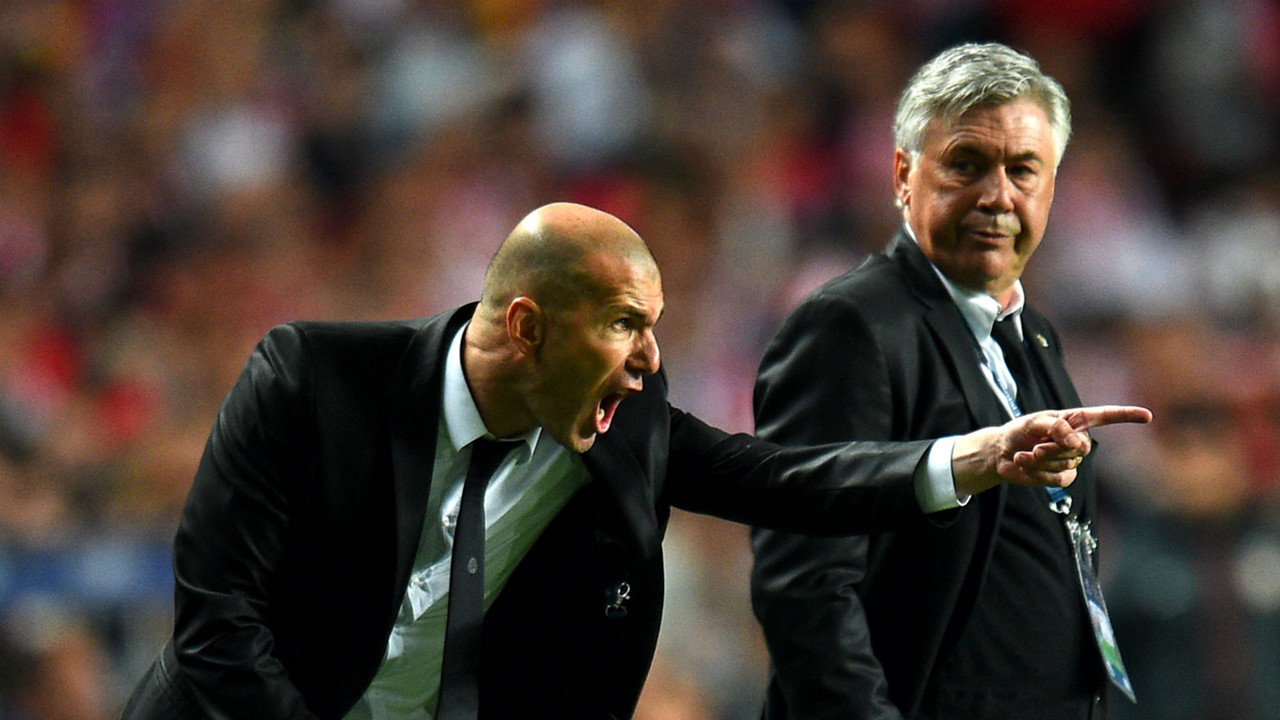

In [ ]:
file_name = wget.download(imgs[0])
img = Image.open(file_name)
print(f'\n{file_name} = {img.size}')
display(img)

Invocamos el modelo y vemos que el resultado es que ha identificado a dos personas y dos corbatas:

In [ ]:
results = model(imgs)
print(results)

image 1/1: 720x1280 2 persons, 2 ties
Speed: 559.0ms pre-process, 35.6ms inference, 36.3ms NMS per image at shape (1, 3, 384, 640)


Veamos dónde están las coordenadas de las bounding boxes de cada objeto detectado (4 en total):

In [ ]:
# Results
results.print()
results.save()
results.xyxy[0]
results.pandas().xyxy[0]

image 1/1: 720x1280 2 persons, 2 ties
Speed: 559.0ms pre-process, 35.6ms inference, 36.3ms NMS per image at shape (1, 3, 384, 640)
Saved 1 image to runs\detect\exp12


,xmin,ymin,xmax,ymax,confidence,class,name
0,742.974854,48.395569,1141.844482,720.000000,0.881052,0,person
1,442.007660,437.522400,496.654022,709.973572,0.675214,27,tie
2,123.024200,193.287354,715.661987,719.723877,0.665814,0,person
3,982.803101,308.417358,1027.365845,419.987000,0.260076,27,tie


### 4.3.3.- Modelo de segmentación

Probemos ahora un modelo U-Net en Keras ya pre-entrenado para segmentación de imágenes:

Dataset: https://www.kaggle.com/dansbecker/cityscapes-image-pairs
Kaggle Link: https://www.kaggle.com/gokulkarthik/image-segmentation-with-unet-pytorch
References: https://arxiv.org/pdf/1603.07285v1.pdf  https://towardsdatascience.com/u-net-b229b32b4a71

In [ ]:
import os
import gc
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

Utilicemos cuda si está disponible y limpiemos la caché (para optimizar memoria). Dependiendo del tipo de tarjeta, es posible que haya que cambiar la memoria de GPU asignada (8192M en mi caso).

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)
torch.cuda.empty_cache()
gc.collect()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8192"

cuda:0


Creamos los paths y vemos las dimensiones:

In [ ]:
data_dir = os.path.join("data", "cityscapes_data", "cityscapes_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


Veamos un ejemplo de imagen (está partido en dos, a la derecha la entrada y la izquierda el ground truth):

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

data\cityscapes_data\cityscapes_data\train\1.jpg


Como la imagen contiene entradas y salidas (por cómo nos han pasado los datos, ya que la salida es también una imagen, no un escalar como en otras ocasiones), debemos separar ambas imágenes y asignar cada mitad al objeto (entrada: cityscape / salida: label) correcta:

In [ ]:
# we need to separate intput / output (which are initially merged)
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

(256, 512, 3)
0 255 0 255


Necesitamos crear ahora una etiqueta para cada tripleta R-G-B (necesitaríamos una etiqueta y tenemos tres escalares, por lo que habrá que clusterizar), como vemos en esta comprobación:

In [ ]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

(256, 512, 3)
0 255 0 255


In [ ]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[223 124 195]
 [ 47 195  18]
 [205 129  95]
 [124 221   8]
 [  7 223 243]]


In [ ]:
# creation of ordinal labels by means of clustering
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

Clusterizamos para tener una etiqueta (el id de cluster 0-9) en lugar de tres valores R-G-B:

In [ ]:
# creation of ordinal labels
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [ ]:
label_model.predict(color_array[:5, :])

array([0, 6, 4, 6, 7])

Aplicamos todo ello:

In [ ]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [ ]:
label_class

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 8, 8, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 8, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

Creamos una clase de acceso a los datos para ser utilizada en PyTorch. Obsérvese que siempre hay que definir un constructor con la estructura de los datos y un sistema para extraer registros de él (__getitem__), así como para definir su tamaño (__len__):

In [ ]:
class CityscapeDataset(Dataset):

    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class

    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


Comprobemos el formato de entradas y salidas (ahora la entrada es RGB mienras que la salida es el cluster por pixel, una matriz con formato de tensor):

In [ ]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


Definimos la red U-Net que vamos a utilizar, formada de capas convolucionales contractivas y luego expansivas:

In [ ]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

Creamos un objeto para la red neuronal:

In [ ]:
model = UNet(num_classes=num_classes)

Creamos los data-loaders y vemos su tamaño:

In [ ]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [ ]:
batch_size = 4
epochs = 10
lr = 0.01

Veamos que la salida es 4 (por los minibatches de cada iteración -según la características de nuestro equipo, puede que interese bajarlo o subirlo-), 10 (por las 10 etiquetas del cluster de colores) y 256x256 (tamaño de la imagen, tanto en entrada como en salida):

In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


Creamos los data-loaders de entrada de datos, el modelo y el optimizador:

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

model = UNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Procedimiento de entrenamiento:

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

Veamos gráficamente la convergencia de la función de pérdidas:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

Guardamos el modelo:

In [ ]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

Cargamos el modelo para comprobar que se ha guardado bien:

In [ ]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Apliquemos el modelo a los datos de test:

In [ ]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


Transformación para normalización de los datos de entrada (valores de los pixels):

In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Visualización de resultados:

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")